In [2]:
# Versão Python
from platform import python_version
print("Versão python usada neste notebook", python_version())

Versão python usada neste notebook 3.9.12


In [3]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [4]:
# imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [6]:
# Versões dos pacotes usados neste notebook
%reload_ext watermark
%watermark -a "Henrique Bardella" --iversions

Author: Henrique Bardella

pandas    : 1.4.2
seaborn   : 0.11.2
sys       : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
numpy     : 1.22.3
findspark : 2.0.1
pyspark   : 3.3.0
matplotlib: 3.5.1



## Preparando o ambiente Spark

In [7]:
# Definindo semente aleatória (seed)
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_stat = rnd_seed

In [8]:
# Criando o spark context
sc = SparkContext(appName = "Projeto-criptomoeda")

In [9]:
# Criando a sessao spark
spark_session = SparkSession.Builder().getOrCreate()

In [10]:
# Visualiza o objeto spark_session
spark_session

## Carregando os dados

In [14]:
# Carrega os dados a partir da sessao Spark
df_spark = spark_session.read.csv('dados/dataset.csv', header = 'true', inferSchema = 'true')

In [15]:
# Tipo do objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [16]:
# Visualiza os dados
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [17]:
# VCisualiza os metadados
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



## Datawrangling

In [42]:
# Cria trabela temporária a partir do dataframe
# As tabelas temporárias sao uteias quando vc deseja que o conjunto de 
    # resultados fique visivel para todas as outras sessoes de spark
df_spark.createOrReplaceTempView('dados_bitcoin')

In [43]:
# Executa consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from dados_bitcoin")

In [44]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [45]:
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:20:00|


In [46]:
# Remove valores NA
df_bitcoin = df_bitcoin.dropna('any')

In [47]:
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 20:45:00|


In [48]:
# Numero de registros
df_bitcoin.count()

3613769

In [49]:
# Renomeia as colunas
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)","VolCurrency")

In [50]:
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 20:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

In [51]:
df_data = df_bitcoin.withColumn("date", split(col("dateTime"), " ").getItem(0))

In [52]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [53]:
# vamos dividor o datafrme extraindo o tempo
df_data = df_data.withColumn("time", split(col("dateTime"), " ").getItem(1))

In [54]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [55]:
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:2

In [56]:
# Exrtai a hora
df_data_hora = df_data.withColumn("hour", split(col("Time"), ":").getItem(0))

In [57]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [58]:
# Vamos ajustar o formato da data para extrair o dia da semana
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["dateTime"].cast(DateType()))

In [59]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|13:28:00|13.0|
|132545790

In [60]:
# Extrair o dia da semana
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [61]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [66]:
# Extrair o ano
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"), "-").getItem(0))

In [67]:
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|  

In [75]:
df_data_hora_ano.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- year: string (nullable = true)



In [76]:
# Converte o dataframe do spark para df do pandas
# Facilita a análise exploratória
df_pandas = df_data_hora_ano.toPandas()

In [73]:
type(df_pandas)

pandas.core.frame.DataFrame

In [78]:
# Obtendo os valores individuais para usar nos gráficos
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()                                             
      

# Análise Exploratória

<AxesSubplot:>

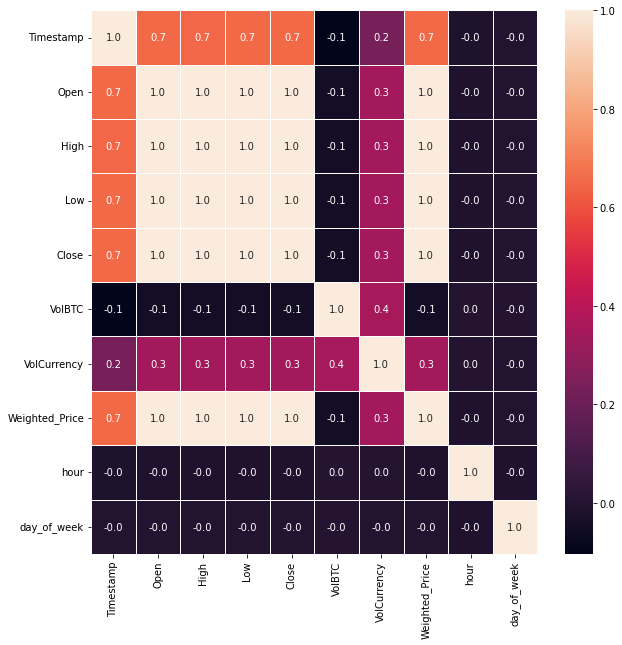

In [79]:
# Heatmap para visualizar a correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

Idealmente queremos alta correlação entre as variáveis de entrada e a variável de saída e baixa correlação entre as variáveis de entrada!

<Figure size 864x360 with 0 Axes>

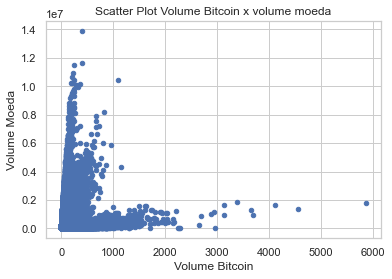

In [80]:
# Scatter plot volume bitcoin x volume moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y  = 'VolCurrency')
plt.xlabel('Volume Bitcoin')
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x volume moeda')
plt.show()

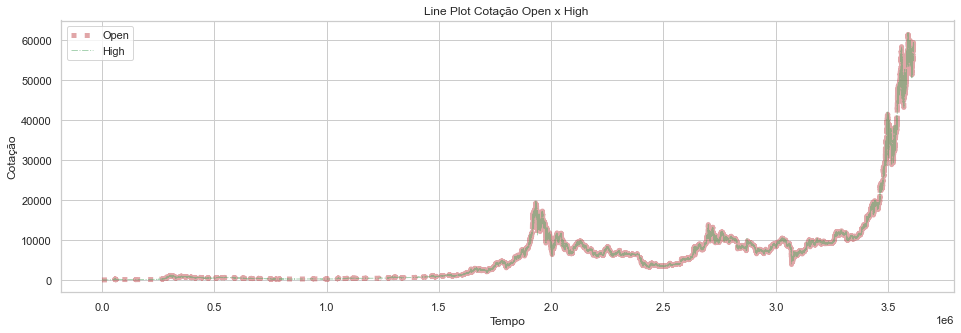

In [81]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

<AxesSubplot:ylabel='Frequency'>

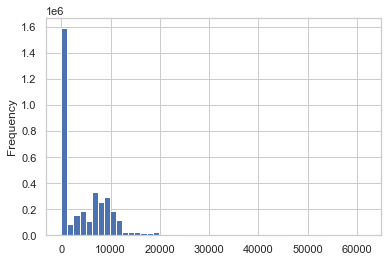

In [83]:
# histograma da cotacao de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

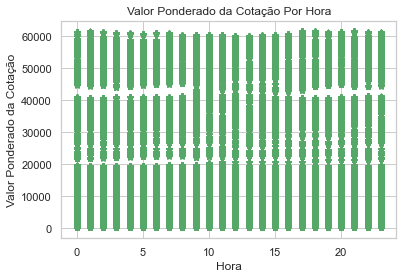

In [86]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

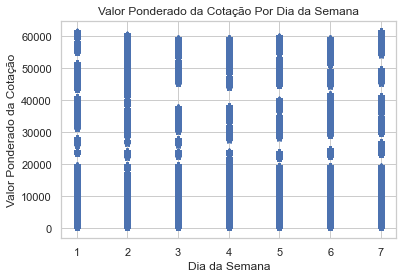

In [87]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

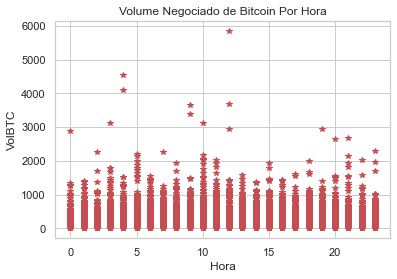

In [88]:
# Plot do VolBTC por hora
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

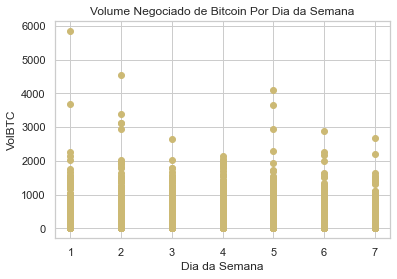

In [89]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

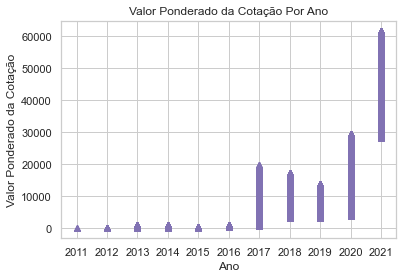

In [90]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

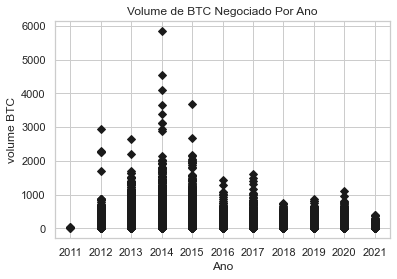

In [91]:
# Plot do Volume por ano
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

## Engenharia de atributos com pyspark

In [93]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [97]:
# Prepara o vetor de atributos
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'],
                           outputCol = "features")

In [98]:
# Cria o df do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [99]:
# Visualiza os dados
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 05:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 13:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 14:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 15:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 02:16:00|[4.58,1.502,6.87916]          |


## Normalização

In [100]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7, .3], seed = rnd_seed)

In [101]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [103]:
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [105]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

In [106]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [107]:
# Transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [108]:
dados_treino_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.553145931914242E-6,0.008199728766573702,1.51589789206087E-5]    |
|[4.5,37.86229723,171.38033753] |[1.1334240936169445E-5,0.006467928495112392,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.2629582757445955E-5,0.001537449143732569,2.9653241795154263E-6] |
|[4.84,10.0,48.4]               |[1.68394436765946E-5,0.001708276826369521,3.4818459555688167E-6]   |
|[5.0,10.1,50.5]                |[1.9430127319147618E-5,0.0017253595946332162,3.63291778421953E-6]  |
|[5.14,0.68,3.4952]             |[2.16969755063815E-5,1.1616282419312745E-4,2.5144107404760596E-7]  |
|[5.26,29.31939163,154.21999997]|[2.3639988238296265E-5,0.00500856372847815,1.1094

In [109]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

# Machine Learning

In [111]:
# criao o modelo de regressao
modelo_lr_v1 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price', 
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [112]:
# Treina o modelo
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

In [124]:
# Salva o modelo em disco
modelo_v1.write().overwrite().save("modelo_v1")

Py4JJavaError: An error occurred while calling o832.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1599)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1599)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1585)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1585)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.regression.InternalLinearRegressionModelWriter.write(LinearRegression.scala:781)
	at org.apache.spark.ml.util.GeneralMLWriter.saveImpl(ReadWrite.scala:260)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:343)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:344)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:901)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1046)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1055)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 22 more


## Avaliação do modelo

In [118]:
# Previsões com dados de teste
# transform = predict do sklearn
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [119]:
# Seleciona as colunas
pred_data_v1 = previsoes_v1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.454429992386768|          4.39|
|7.644330277501783|          4.58|
| 8.06410985512445|           5.0|
| 8.38394191426553|          5.32|
|8.353957658721052|          5.29|
|8.353957658721052|          5.29|
|8.254010140239465|          5.19|
|8.423920921658164|  5.3604618117|
|8.813716243736355|   5.777027027|
|9.063585039940323|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [120]:
# Mean Absolute Error
print("Mean Absolute Error (MAE) nos dados de teste: {0}".format(modelo_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 5.019115742935882


In [121]:
# Cria um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [125]:
# Aplica o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v1)

Root Mean Squared Error (RMSE) nos dados de teste = 11.325


In [126]:
# Extrai as previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

In [127]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

Exception ignored in: <function JavaWrapper.__del__ at 0x000001EE7B671EE0>
Traceback (most recent call last):
  File "C:\Users\henri\anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


In [128]:
# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

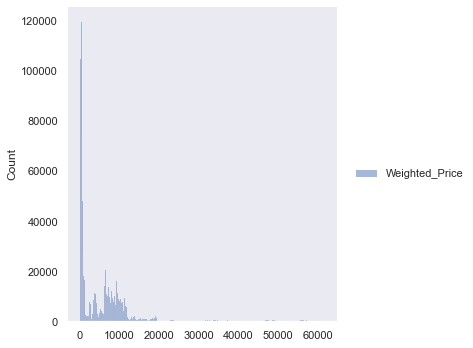

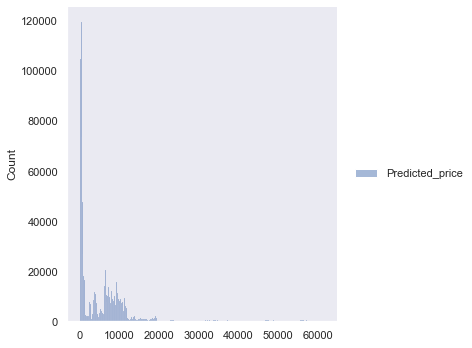

In [129]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

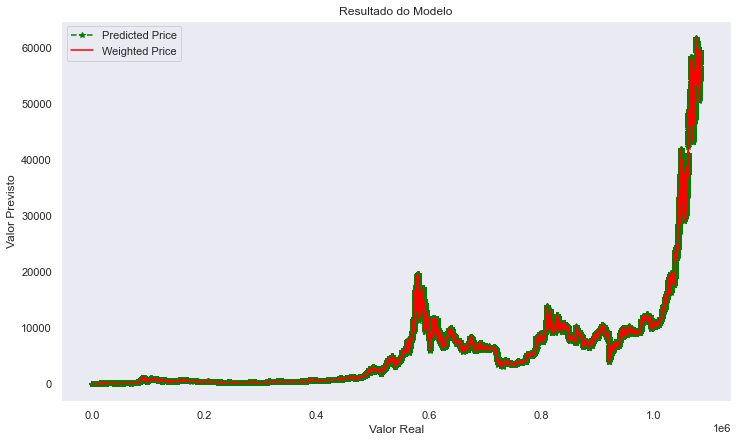

In [130]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

## Previsões

In [131]:
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [132]:
# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [133]:
# Visualiza
df_novos_dados

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [134]:
# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados) 

In [135]:
# Schema
df_novos_dados_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [136]:
# Visualiza
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [137]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [138]:
# Visualiza os dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [139]:
# Normaliza os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [140]:
# Previsões com os novos dados
previsoes = modelo_v1.transform(df_assembled_scaled)

In [141]:
# Imprime as previsões
pred_data = previsoes.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
|20538.573728961557|
|21612.569783557297|
+------------------+



In [142]:
previsoes.show()

+--------+-------+-------------+--------------------+--------------------+------------------+
|    Open| VolBTC|  VolCurrency|            features|     scaled_features|   Predicted_price|
+--------+-------+-------------+--------------------+--------------------+------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|[0.33261933012693...|20538.573728961557|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|[0.35001836147031...|21612.569783557297|
+--------+-------+-------------+--------------------+--------------------+------------------+



In [144]:
# Encerra a sessao spark
spark_session.stop()